In [1]:
%autosave 60
%reload_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "..")

Autosaving every 60 seconds


In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"dotyushka666","key":"52b47ed42f652aa8eadfc6f29eb2e56c"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c teta-nn-1-2025
!unzip /kaggle/working/teta-nn-1-2025

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 6.3 MB/s eta 0:00:00
  0%|                                               | 0.00/20.3M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 20.3M/20.3M [00:00<00:00, 1.06GB/s]
Archive:  /kaggle/working/teta-nn-1-2025.zip
  inflating: sample_submition.csv    
  inflating: test.csv                
  inflating: train.csv               


In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


from tqdm import tqdm

/home/silverservicepipe/education/shad_mts/ml_dl/teta_nn_1_2025_predict_salary/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# df_train = pd.read_csv("../src/data/train.csv").sample(50)
df_train = pd.read_csv("/kaggle/working/train.csv")
df_train = df_train.drop(columns=["company", "salary_from"])

df_train.head()

,title,location,skills,description,experience_from,log_salary_from
0,Специалист технической поддержки,Воронеж,NaN,Обязанности: Обеспечение бесперебойной раб...,1.0,4.094345
1,Product Owner в ИТ-стартап (B2C),Москва,"CustDev, Стратегический менеджмент, Управление...","Эта вакансия про тебя, если симбиоз управленче...",6.0,5.298317
2,Системный администратор ( Клинический Госпитал...,Москва,NaN,АО «Медскан» – динамично развивающаяся группа ...,1.0,4.867534
3,Системный Администратор Linux,Москва,"Linux, PostgreSQL",Задачи: Администрирование инфраструктуры н...,3.0,5.135798
4,Начальник участка общестроительных работ,Пушкино (Московская область),NaN,NK Group – ведущий девелопер индустриальных о...,3.0,5.298317


In [5]:
from collections import Counter
import re

In [6]:
def clean_text(text):
    # Удаляем HTML-теги
    text = re.sub(r'<.*?>', '', text)
    # Удаляем ссылки
    text = re.sub(r'http\S+|www\S+', '', text)
    # Удаляем спецсимволы
    text = re.sub(r'[^а-яА-ЯёЁa-zA-Z0-9\-\s]', '', text)
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# Применяем очистку к тексту
df_train["clean_description"] = df_train["description"].apply(clean_text)

In [8]:
# Собираем все тексты в один список
all_texts = df_train["clean_description"].tolist()

# Разбиваем тексты на слова
all_words = []
for text in all_texts:
    words = re.findall(r'\b\w+\b', text.lower())  # Разбиваем текст на слова
    all_words.extend(words)

# Считаем частоту слов
word_counts = Counter(all_words)

# Выводим самые частотные слова
print(word_counts.most_common(50))

[('и', 178502), ('в', 113539), ('с', 72381), ('на', 49656), ('работы', 47827), ('по', 43168), ('опыт', 33087), ('для', 29002), ('мы', 27034), ('от', 20226), ('компании', 16475), ('знание', 16268), ('работа', 13532), ('к', 13222), ('до', 13070), ('1с', 11429), ('условия', 11329), ('требования', 10929), ('или', 10552), ('умение', 10464), ('график', 10318), ('обязанности', 9769), ('за', 9243), ('возможность', 8737), ('что', 8694), ('не', 8653), ('рф', 8495), ('работать', 8350), ('систем', 8165), ('разработка', 7974), ('данных', 7751), ('тк', 7746), ('будет', 7285), ('лет', 7147), ('разработки', 6962), ('оборудования', 6784), ('оформление', 6716), ('а', 6584), ('образование', 6529), ('компания', 6326), ('навыки', 6310), ('из', 6261), ('обучение', 6209), ('понимание', 6198), ('участие', 6175), ('52', 6169), ('сотрудников', 6117), ('it', 6032), ('у', 5929), ('пользователей', 5764)]


# Предобработка данных

In [7]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

Статистика по количеству токенов:
Mean: 328.12
Median: 305.00
Min: 26.00
Max: 1533.00
Std: 162.24


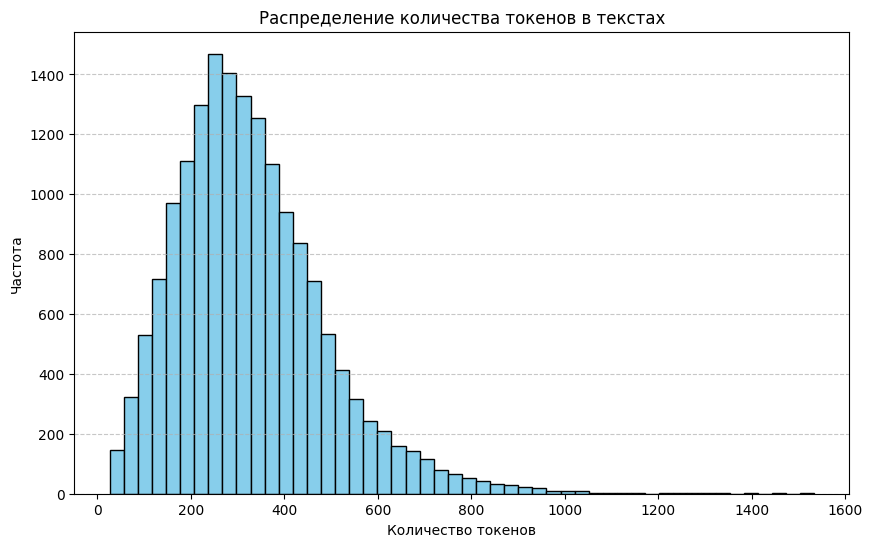

In [9]:
# Подсчёт количества токенов для каждого текста
token_counts = df_train["description"].apply(lambda x: len(tokenizer.tokenize(x)))

# Построение статистики
stats = {
    "mean": token_counts.mean(),
    "median": token_counts.median(),
    "min": token_counts.min(),
    "max": token_counts.max(),
    "std": token_counts.std()
}

print("Статистика по количеству токенов:")
for key, value in stats.items():
    print(f"{key.capitalize()}: {value:.2f}")

# Построение гистограммы
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=50, color="skyblue", edgecolor="black")
plt.title("Распределение количества токенов в текстах")
plt.xlabel("Количество токенов")
plt.ylabel("Частота")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Статистика по количеству токенов:
Mean: 262.51
Median: 242.00
Min: 20.00
Max: 1356.00
Std: 133.46


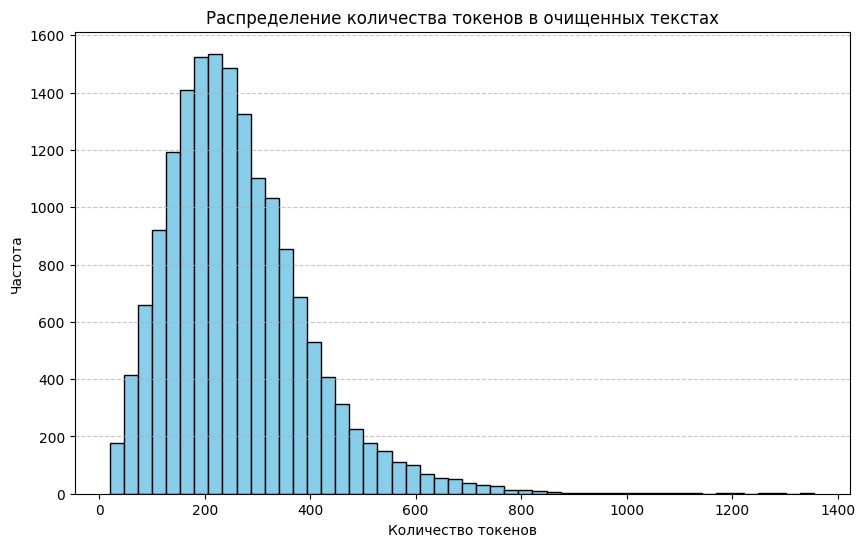

In [ ]:
# Подсчёт количества токенов для каждого текста
token_counts = df_train["clean_description"].apply(lambda x: len(tokenizer.tokenize(x)))

# Построение статистики
stats = {
    "mean": token_counts.mean(),
    "median": token_counts.median(),
    "min": token_counts.min(),
    "max": token_counts.max(),
    "std": token_counts.std()
}

print("Статистика по количеству токенов:")
for key, value in stats.items():
    print(f"{key.capitalize()}: {value:.2f}")


plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=50, color="skyblue", edgecolor="black")
plt.title("Распределение количества токенов в очищенных текстах")
plt.xlabel("Количество токенов")
plt.ylabel("Частота")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [17]:
df_train["tokens_counts"] = df_train["clean_description"].apply(lambda x: len(tokenizer.tokenize(x)))

In [40]:
df_train[df_train["tokens_counts"] > 1024][["tokens_counts", "clean_description"]]

,tokens_counts,clean_description
575,1356,обязанности проводить мониторинг нормативных п...
606,1094,aspnet coreweb api restful api react javascrip...
2028,1178,привет мы ищем дизайнера универсала с возможно...
3401,1274,привет на связи никита основатель агентства ищ...
4953,1129,карты и навигатор ежедневно помогают миллионам...
5743,1096,привет меня зовут толя я руковожу командой reg...
5853,1276,stellar 2h group c 2005 года мы разрабатываем ...
6331,1209,яндекс еда динамично развивающийся сервис пред...
7787,1338,обязанности управление проектной деятельностью...
9997,1121,обязанности организовывать и контролировать ра...


In [ ]:
# class SalaryDataset(Dataset):
#     def __init__(self, df, tokenizer, max_length=128, chunk_size=512):
#         self.df = df
#         self.tokenizer = tokenizer
#         self.max_length = max_length
#         self.chunk_size = chunk_size

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
        
#         # Текст вакансии
#         text = f"{row['title']} {row['clean_description']}"
        
#         # Токенизация текста с разбиением на части
#         tokens = self.tokenizer(
#             text,
#             truncation=False,  # Не обрезаем текст
#             padding=False,     # Не дополняем до max_length
#             return_tensors="pt"
#         )

#         input_ids = tokens["input_ids"].squeeze(0)
#         attention_mask = tokens["attention_mask"].squeeze(0)
        
#         # Разбиваем текст на части (chunks)
#         input_chunks = []
#         attention_chunks = []
#         for i in range(0, len(input_ids), self.chunk_size):
#             input_chunks.append(input_ids[i:i + self.chunk_size])
#             attention_chunks.append(attention_mask[i:i + self.chunk_size])
        
#         # Если последняя часть меньше chunk_size, дополняем ее
#         if len(input_chunks[-1]) < self.chunk_size:
#             padding_length = self.chunk_size - len(input_chunks[-1])
#             input_chunks[-1] = torch.cat([input_chunks[-1], torch.zeros(padding_length, dtype=torch.long)])
#             attention_chunks[-1] = torch.cat([attention_chunks[-1], torch.zeros(padding_length, dtype=torch.long)])
        
#         # Преобразуем в тензоры
#         input_chunks = torch.stack(input_chunks)
#         attention_chunks = torch.stack(attention_chunks)
        
#         # Целевая переменная
#         target = row["log_salary_from"]
        
#         return {
#             "input_ids": input_chunks,          # [num_chunks, chunk_size]
#             "attention_mask": attention_chunks, # [num_chunks, chunk_size]
#             "target": torch.tensor(target, dtype=torch.float)
#         }

In [8]:
class SalaryDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512, columns_features=None):
        self.df = df[["log_salary_from", "title", "clean_description"] + columns_features if columns_features is not None else []]
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.columns_features = columns_features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Текст вакансии
        text = f"{row['title']} {row['clean_description']}"
        
        # Токенизация текста с обрезкой до max_length
        tokens = self.tokenizer(
            text,
            truncation=True,  # Обрезаем текст до max_length
            max_length=self.max_length,
            padding="max_length",  # Дополняем до max_length
            return_tensors="pt"
        )

        input_ids = tokens["input_ids"].squeeze(0)  # [max_length]
        attention_mask = tokens["attention_mask"].squeeze(0)  # [max_length]

        additional_features = torch.tensor(row[self.columns_features].values.astype(float), dtype=torch.float)

        # Целевая переменная
        target = row["log_salary_from"]
        
        return {
            "input_ids": input_ids,          # [max_length]
            "attention_mask": attention_mask, # [max_length]
            "features": additional_features,
            "target": torch.tensor(target, dtype=torch.float)
        }

# Модель

In [9]:
class TransformerTextEncoder(nn.Module):
    def __init__(self, num_features, vocab_size, embedding_dim=128, hidden_dim=256, num_heads=8, num_layers=4, max_length=512, dropout=0.3):
        super(TransformerTextEncoder, self).__init__()
        
        # Эмбеддинги для токенов
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Позиционные эмбеддинги (необучаемые)
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(dropout)
        self.positional_encoding = self._generate_positional_encoding(max_length, embedding_dim)
        
        # Трансформерный энкодер
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Attention Pooling
        self.attention_weights = nn.Linear(embedding_dim, 1)
        
        self.activation = nn.ReLU()
        # Финальный линейный слой для агрегации
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(embedding_dim + num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.final_norm = nn.LayerNorm(embedding_dim)
    
    def _generate_positional_encoding(self, max_len, d_model):
        """Генерация необучаемого positional encoding"""
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        return nn.Parameter(pe.unsqueeze(0), requires_grad=True)
    
    def forward(self, input_ids, attention_mask, additional_features):
        # batch_size, num_chunks, chunk_size = input_ids.size()
        # input_ids = input_ids.view(-1, chunk_size) # [batch_size * num_chunks, chunk_size]
        # attention_mask = attention_mask.view(-1, chunk_size) # [batch_size * num_chunks, chunk_size]

        # Эмбеддинги токенов
        embedded = self.token_embedding(input_ids)
        seq_len = embedded.size(1)
        embedded = embedded + self.positional_encoding[:, :seq_len, :].to(embedded.device)
        embedded = self.dropout(embedded)

        # Применяем трансформер
        padding_mask = ~attention_mask.bool()  # Создаем padding mask
        transformer_output = self.transformer(embedded, src_key_padding_mask=padding_mask)
        transformer_output = transformer_output + embedded
        
        # Пуллинг (усреднение по токенам с учетом маски)
        # attention_mask = attention_mask.unsqueeze(-1).float()
        # attention_sum = attention_mask.sum(dim=1)
        # attention_sum = torch.clamp(attention_sum, min=1e-8)
        # pooled_output = (transformer_output * attention_mask).sum(dim=1) / attention_sum

        # pooled_output = pooled_output.view(batch_size, num_chunks, -1) # [batch_size, num_chunks, embedding_dim]
        # count_chunks_in_batch = (attention_mask.sum(dim=1).view(batch_size, num_chunks) > 0).sum(dim=1)

        # aggregated_output = pooled_output.sum(dim=1) / count_chunks_in_batch.unsqueeze(-1)

        # Attention Pooling
        attention_scores = self.attention_weights(transformer_output).squeeze(-1)  # [batch_size, seq_len]
        attention_scores = attention_scores.masked_fill(~attention_mask.bool(), float('-inf'))  # Маскируем паддинги
        attention_weights = torch.softmax(attention_scores, dim=1)  # [batch_size, seq_len]
        pooled_output = torch.sum(transformer_output * attention_weights.unsqueeze(-1), dim=1)  # [batch_size, embedding_dim]

        conbined_features = torch.cat([self.final_norm(pooled_output), additional_features], dim=1) # [batch_size, embedding_dim + num_features]
        
        # Финальное предсказание
        output = self.fc(conbined_features)
        
        return output.squeeze()

In [20]:
# def collate_fn(batch):
#     # Находим максимальное количество частей (num_chunks) в батче
#     max_chunks = max(item["input_ids"].size(0) for item in batch)
#     chunk_size = batch[0]["input_ids"].size(1)  # Размер одной части (chunk_size)

#     # Дополняем input_ids и attention_mask до max_chunks
#     input_ids = []
#     attention_mask = []
#     targets = []

#     for item in batch:
#         num_chunks = item["input_ids"].size(0)
#         padding_chunks = max_chunks - num_chunks

#         # Дополняем недостающие части нулями
#         padded_input_ids = torch.cat([
#             item["input_ids"],
#             torch.zeros(padding_chunks, chunk_size, dtype=torch.long)
#         ])
#         padded_attention_mask = torch.cat([
#             item["attention_mask"],
#             torch.zeros(padding_chunks, chunk_size, dtype=torch.long)
#         ])

#         input_ids.append(padded_input_ids)
#         attention_mask.append(padded_attention_mask)
#         targets.append(item["target"])

#     # Преобразуем в тензоры
#     input_ids = torch.stack(input_ids)  # [batch_size, max_chunks, chunk_size]
#     attention_mask = torch.stack(attention_mask)  # [batch_size, max_chunks, chunk_size]
#     targets = torch.tensor(targets, dtype=torch.float)  # [batch_size]

#     return {
#         "input_ids": input_ids,
#         "attention_mask": attention_mask,
#         "target": targets
#     }

In [56]:
num_bins = 10  # Количество бинов
df_train["target_bins"] = pd.qcut(df_train["log_salary_from"], q=num_bins, labels=False)

In [ ]:
df_train["skills_str"] = df_train["skills"].fillna("").apply(lambda x: ", ".join(x.split(",")))

# Разделение данных на train/val
train_df, val_df = train_test_split(df_train, test_size=0.3, random_state=64, stratify=df_train["target_bins"])
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# # Обучение TfidfVectorizer на train
tfidf = TfidfVectorizer(max_features=500, token_pattern=r"[^,]+")
skills_tfidf_train = tfidf.fit_transform(train_df["skills_str"])

# # Применение TfidfVectorizer к val
skills_tfidf_val = tfidf.transform(val_df["skills_str"])

# # Преобразование в DataFrame
skills_tfidf_train_df = pd.DataFrame(skills_tfidf_train.toarray(), columns=tfidf.get_feature_names_out())
skills_tfidf_val_df = pd.DataFrame(skills_tfidf_val.toarray(), columns=tfidf.get_feature_names_out())

# # Добавление TF-IDF признаков
train_df = pd.concat([train_df, skills_tfidf_train_df], axis=1)
val_df = pd.concat([val_df, skills_tfidf_val_df], axis=1)

# # Обучение OrdinalEncoder на train
label_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
train_df["location_encoded"] = label_encoder.fit_transform(train_df[["location"]])

# # Применение OrdinalEncoder к val
val_df["location_encoded"] = label_encoder.transform(val_df[["location"]])

# # Заполнение пропущенных значений
train_df = train_df.fillna(0)
val_df = val_df.fillna(0)

In [58]:
assert df_train.shape[0] == train_df.shape[0] + val_df.shape[0]

In [60]:
num_features = ["location_encoded", "experience_from"] + tfidf.get_feature_names_out().tolist()

In [61]:
# Создание датасетов и загрузчиков
train_dataset = SalaryDataset(train_df, tokenizer, max_length=1024, columns_features=num_features)
val_dataset = SalaryDataset(val_df, tokenizer, max_length=1024, columns_features=num_features)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Обучение модели

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [63]:
model = TransformerTextEncoder(
    num_features=len(num_features),
    vocab_size=tokenizer.vocab_size,
    embedding_dim=512,
    hidden_dim=512,
    num_heads=4,
    num_layers=4,
    max_length=1024,
    dropout=0.1
).to(device)

# Обучение
num_epochs = 50

# Оптимизатор и функция потерь
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.SmoothL1Loss()

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,  # Максимальное значение LR
    total_steps=len(train_loader) * num_epochs,  # Общее количество шагов (итераций)
    pct_start=0.3,  # Доля итераций, на которых LR увеличивается
    anneal_strategy="linear",  # Линейное уменьшение LR
    final_div_factor=10  # Минимальный LR = max_lr / final_div_factor
)

# Функция обучения
def train_epoch(model, dataloader, optimizer, criterion, scheduler):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        features = batch["features"].to(device)
        targets = batch["target"].to(device)

        outputs = model(input_ids, attention_mask, features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    return total_loss / len(dataloader)

# Функция валидации
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features = batch["features"].to(device)
            batch_targets = batch["target"].to(device)

            outputs = model(input_ids, attention_mask, features)
            loss = criterion(outputs, batch_targets)

            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            targets.extend(batch_targets.cpu().numpy())
    return total_loss / len(dataloader), predictions, targets

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, scheduler)
    val_loss, val_preds, val_targets = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val R2: {r2_score(val_targets, val_preds)}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
100%|██████████| 79/79 [00:42<00:00,  1.85it/s]


Epoch 1/50
Train Loss: 0.8013
Val Loss: 0.1412
Val R2: 0.2732820888815397


100%|██████████| 79/79 [00:43<00:00,  1.83it/s]


Epoch 2/50
Train Loss: 0.1164
Val Loss: 0.0923
Val R2: 0.5289884871213848


100%|██████████| 79/79 [00:42<00:00,  1.84it/s]


Epoch 3/50
Train Loss: 0.0971
Val Loss: 0.0937
Val R2: 0.5193373774871919


100%|██████████| 79/79 [00:42<00:00,  1.86it/s]


Epoch 4/50
Train Loss: 0.0895
Val Loss: 0.0836
Val R2: 0.5720487577644381


100%|██████████| 79/79 [00:41<00:00,  1.88it/s]


Epoch 5/50
Train Loss: 0.0823
Val Loss: 0.0753
Val R2: 0.6143069344003274


100%|██████████| 79/79 [00:42<00:00,  1.86it/s]


Epoch 6/50
Train Loss: 0.0772
Val Loss: 0.0748
Val R2: 0.6164859740048317


100%|██████████| 79/79 [00:42<00:00,  1.87it/s]


Epoch 7/50
Train Loss: 0.0734
Val Loss: 0.0798
Val R2: 0.5901006203913943


100%|██████████| 79/79 [00:42<00:00,  1.87it/s]


Epoch 8/50
Train Loss: 0.0705
Val Loss: 0.0694
Val R2: 0.6445070203122419


100%|██████████| 79/79 [00:42<00:00,  1.87it/s]


Epoch 9/50
Train Loss: 0.0701
Val Loss: 0.0798
Val R2: 0.5901655591118368


100%|██████████| 79/79 [00:42<00:00,  1.87it/s]


Epoch 10/50
Train Loss: 0.0667
Val Loss: 0.0735
Val R2: 0.6219772772639828


100%|██████████| 79/79 [00:42<00:00,  1.88it/s]


Epoch 11/50
Train Loss: 0.0637
Val Loss: 0.0702
Val R2: 0.6397477587585276


100%|██████████| 79/79 [00:42<00:00,  1.86it/s]


Epoch 12/50
Train Loss: 0.0602
Val Loss: 0.0727
Val R2: 0.6258785466458796


100%|██████████| 79/79 [00:42<00:00,  1.87it/s]


Epoch 13/50
Train Loss: 0.0576
Val Loss: 0.0668
Val R2: 0.6566470819808834


100%|██████████| 79/79 [00:42<00:00,  1.88it/s]


Epoch 14/50
Train Loss: 0.0561
Val Loss: 0.0675
Val R2: 0.6526839572839642


100%|██████████| 79/79 [00:42<00:00,  1.87it/s]


Epoch 15/50
Train Loss: 0.0546
Val Loss: 0.0700
Val R2: 0.6403980060707208


 93%|█████████▎| 339/365 [05:00<00:23,  1.13it/s]


KeyboardInterrupt: 

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=3e-6, weight_decay=1e-4)
criterion = nn.SmoothL1Loss()

for epoch in range(10):
    train_loss = train_epoch(model, val_loader, optimizer, criterion, optim.lr_scheduler.LinearLR(optimizer))

In [37]:
df_test = pd.read_csv("/kaggle/working/test.csv")

df_test = df_test.fillna("")
df_test.head()

,title,location,company,skills,description,experience_from
0,Ведущий программист 1С (г. Санкт-Петербург),Санкт-Петербург,Коннект персонал,"1С программирование, MS SQL Server, 1C: ERP, О...",Крупнейший производственный комплекс легкой пр...,3.0
1,Ресерчер (поиск товаров на маркетплейсах),Москва,Right Choice,"Конкурентная аналитика, Аналитические исследов...","Мы молодая команда селлеров, состоящая из 12 ч...",1.0
2,Системный администратор,Нижний Новгород,Меридиан,"Администрирование сетевого оборудования, Админ...",О компании: Уже более 30 лет мы успешно прои...,1.0
3,Инженер по интеграции систем защиты информации,Новосибирск,СофтМолл,"Информационная безопасность, Аналитическое мыш...","SoftMall – это аккредитованная IT-компания, к...",1.0
4,Ведущий менеджер по работе с маркетплейсом Wil...,Москва,ДЖЕЙКЕТ РАБОТА,,Вакансия компании: Brosco Компания Brosco зан...,1.0


In [38]:
df_test.shape

(5556, 6)

In [ ]:
df_test["clean_description"] = df_test["description"].apply(clean_text)

df_test["skills_str"] = df_test["skills"].apply(lambda x: ",".join(x.split(",")))

skills_tfidf_val = tfidf.transform(df_test["skills_str"])
skills_tfidf_df = pd.DataFrame(skills_tfidf_val.toarray(), columns=tfidf.get_feature_names_out())
df_test = pd.concat([df_test, skills_tfidf_df], axis=1).fillna(0)

df_test["location_encoded"] = label_encoder.transform(df_test[["location"]])

In [41]:
class SalaryDatasetTest(Dataset):
    def __init__(self, df, tokenizer, max_length=512, columns_features=None):
        self.df = df[["title", "clean_description"] + columns_features if columns_features is not None else []]
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.columns_features = columns_features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Текст вакансии
        text = f"{row['title']} {row['clean_description']}"
        
        # Токенизация текста с обрезкой до max_length
        tokens = self.tokenizer(
            text,
            truncation=True,  # Обрезаем текст до max_length
            max_length=self.max_length,
            padding="max_length",  # Дополняем до max_length
            return_tensors="pt"
        )

        input_ids = tokens["input_ids"].squeeze(0)  # [max_length]
        attention_mask = tokens["attention_mask"].squeeze(0)  # [max_length]

        additional_features = torch.tensor(row[self.columns_features].values.astype(float), dtype=torch.float)
        
        return {
            "input_ids": input_ids,          # [max_length]
            "attention_mask": attention_mask, # [max_length]
            "features": additional_features,
        }

In [42]:
test_dataset = SalaryDatasetTest(df_test, tokenizer, max_length=1024, columns_features=num_features)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [43]:
def evaluate_test(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features = batch["features"].to(device)

            outputs = model(input_ids, attention_mask, features)

            predictions.extend(outputs.cpu().numpy())

    return predictions

In [44]:
test_preds = evaluate_test(model, test_loader)

100%|██████████| 87/87 [00:47<00:00,  1.85it/s]


In [47]:
test_predictions = pd.DataFrame({
    "prediction": test_preds
}).reset_index()

In [48]:
print(test_predictions.shape)
test_predictions.head()

(5556, 2)


,index,prediction
0,0,5.560867
1,1,4.061025
2,2,4.590584
3,3,4.580428
4,4,4.758976


In [49]:
test_predictions.to_csv("submission.csv", index=False)

In [50]:
!kaggle competitions submit -c teta-nn-1-2025 -f /kaggle/working/submission.csv -m "Baseline fun!"

100%|███████████████████████████████████████| 77.5k/77.5k [00:00<00:00, 173kB/s]
Successfully submitted to teta_nn_1_2025